In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
# import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.torch_geo_models import DotMLPRelu
from src.data.gamma.structural_products import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.structural_omega.mlp import StructuralOmegaMLP

In [10]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename='logs/gamma_function/products/02-1-structural_mlp_gamma_function.log'
)

In [11]:
torch.cuda.is_available()

True

In [12]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [14]:
dataset = load_dataset()

This will download 1.38GB. Will you proceed? (y/N)
 y


Downloaded 1.38 GB: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1414/1414 [01:40<00:00, 14.01it/s]


Extracting data/gamma/products.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


Converting graphs into PyG objects...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1781.78it/s]


Saving...


Done!


In [15]:
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)

/var/tmp/caio.martinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-5eaRvUat-py3.9/lib/python3.9/site-packages/torch/cuda/__init__.py:132: UserWarning: 
    Found GPU0 Tesla K40c which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [16]:
data = prepare_adjencency(data)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.84 GiB (GPU 0; 11.17 GiB total capacity; 9.25 GiB already allocated; 933.25 MiB free; 10.16 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [20]:
type(T.ToSparseTensor()(data))

torch_geometric.data.data.Data

In [22]:
type(data.adj_t.to_symmetric())

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.84 GiB (GPU 0; 11.17 GiB total capacity; 9.25 GiB already allocated; 933.25 MiB free; 10.16 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Training

In [9]:
for run in range(30):
    for n_layers in range(1, 6):
        omega = StructuralOmegaMLP(device, n_layers=n_layers, run=run)
        torch.cuda.empty_cache()
        omega.train(edges_train,
                    edges_val,
                    edges_test,
                    data.x,
                    data.y)

## Results

### For a Layer Number

In [7]:
n_layers = 3

In [9]:
metrics = StructuralOmegaMLP.read_metrics(n_layers=n_layers)
print(metrics.shape)
metrics.head()

(1530, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0,0,0.711921,0.708201,0.707602,0.417311,0.436905,0.447820
1,0,100,0.563181,0.595271,0.613246,0.709775,0.696999,0.665045
2,0,200,0.545506,0.580902,0.603995,0.734617,0.716961,0.683724
3,0,300,0.536791,0.575919,0.600728,0.746395,0.722850,0.688986
4,0,400,0.531787,0.574041,0.599886,0.752899,0.725031,0.690482


### Sumarize metrics per epoch

In [10]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [11]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [12]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,0.699879,0.009989,0.698596,0.008041,0.698395,0.007725,0.498615,0.030037,0.501891,0.026445,0.502319,0.024996
100,0.560307,0.002376,0.592036,0.002079,0.611683,0.001462,0.712275,0.003575,0.700206,0.003163,0.668368,0.003056
200,0.541821,0.002472,0.578451,0.001586,0.602491,0.001145,0.740053,0.003637,0.720061,0.002139,0.686119,0.001906
300,0.532377,0.003076,0.573547,0.001965,0.599144,0.001574,0.753241,0.004289,0.726276,0.002483,0.691585,0.002349
400,0.526575,0.003610,0.571073,0.002159,0.597408,0.001610,0.760808,0.004787,0.729150,0.002685,0.694078,0.002460


In [13]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
1400,0.508406,0.003802,0.567125,0.002815,0.595385,0.003015,0.786430,0.004693,0.734971,0.002214,0.698447,0.001908
1500,0.507821,0.003899,0.567643,0.003457,0.595960,0.003522,0.787378,0.004671,0.734967,0.002215,0.698370,0.001926
1300,0.509010,0.003869,0.566811,0.002586,0.594890,0.002302,0.785337,0.004689,0.734961,0.002205,0.698485,0.001907
1200,0.509744,0.003760,0.566624,0.002397,0.594518,0.001963,0.784063,0.004642,0.734905,0.002177,0.698525,0.001910
1600,0.507346,0.003847,0.568239,0.003813,0.596687,0.004172,0.788314,0.004671,0.734861,0.002145,0.698270,0.001832


/tmp/ipykernel_105465/1412324280.py:8: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_105465/1412324280.py:9: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_105465/1412324280.py:56: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future beha

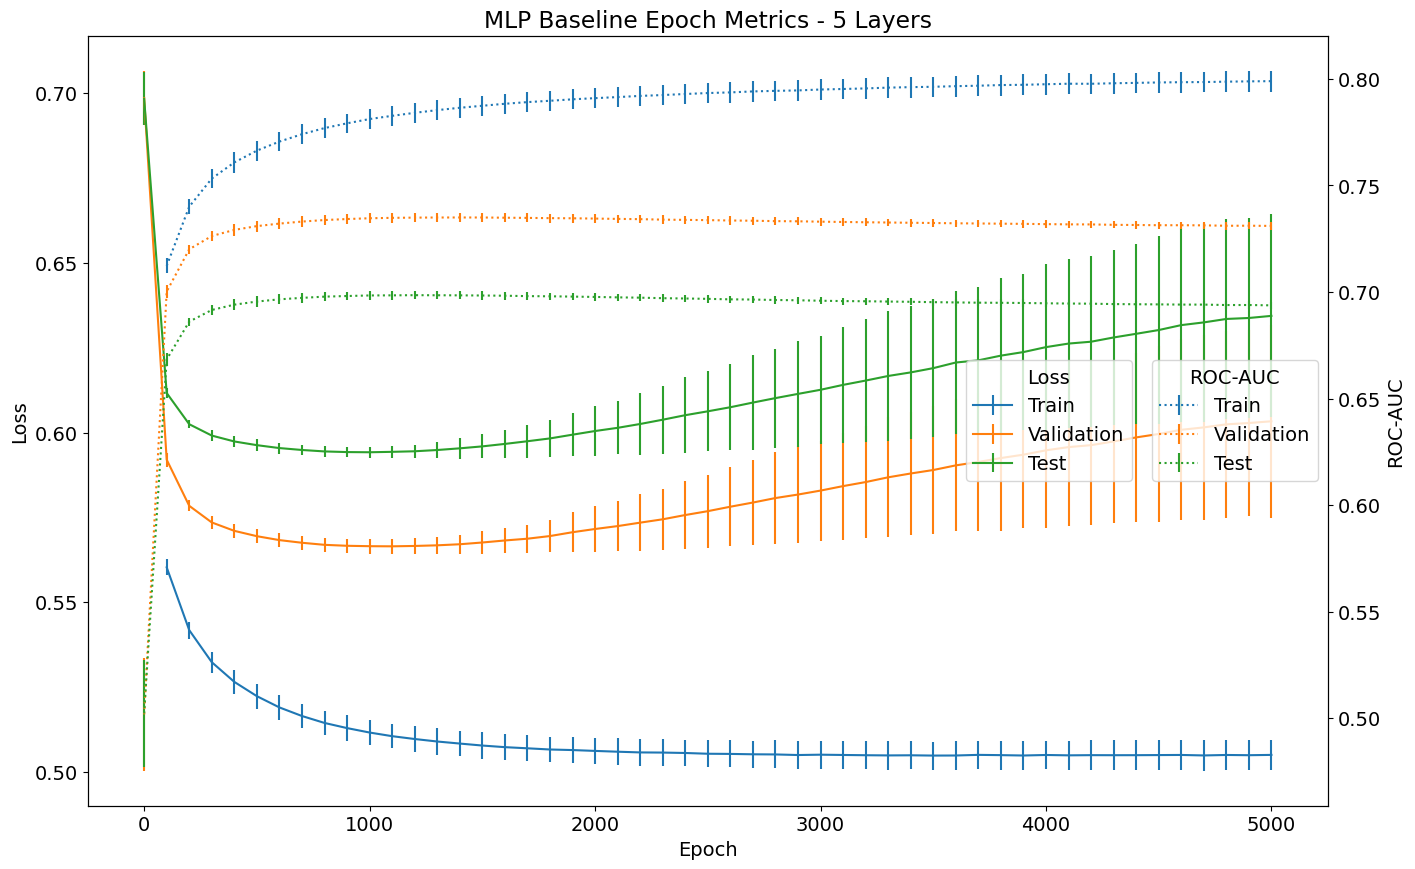

In [31]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title(f'MLP Baseline Epoch Metrics - {n_layers} Layers')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

# ax1.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['loss_train_mean'][1:],
#     # yerr=epoch_metrics['loss_train_std'][1:],
#     ls='-',
#     label='Train')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_val_mean'],
#     # yerr=epoch_metrics['loss_val_std'],
#     ls='-',
#     label='Validation')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_test_mean'],
#     # yerr=epoch_metrics['loss_test_std'],
#     ls='-',
#     label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

# ax2.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['auc_train_mean'][1:],
#     # yerr=epoch_metrics['auc_train_std'][1:],
#     ls=':',
#     label='Train')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_val_mean'],
#     # yerr=epoch_metrics['auc_val_std'],
#     ls=':',
#     label='Validation')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_test_mean'],
#     # yerr=epoch_metrics['auc_test_std'],
#     ls=':',
#     label='Test')

ax2.legend(loc='center right', title='ROC-AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC-AUC')

plt.savefig(f'reports/images/structural_omega_dotmlp_training_metrics_{n_layers}layers.pdf')

### Comparing Validation Performance for All Layer numbers

In [21]:
n_layers_list = range(1, 6)

In [22]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers in n_layers_list:
    metrics = StructuralOmegaMLP.read_metrics(n_layers=n_layers)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers] = auc_val
    mean_loss_val_dict[n_layers] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers] = auc_val
    std_loss_val_dict[n_layers] = loss_val

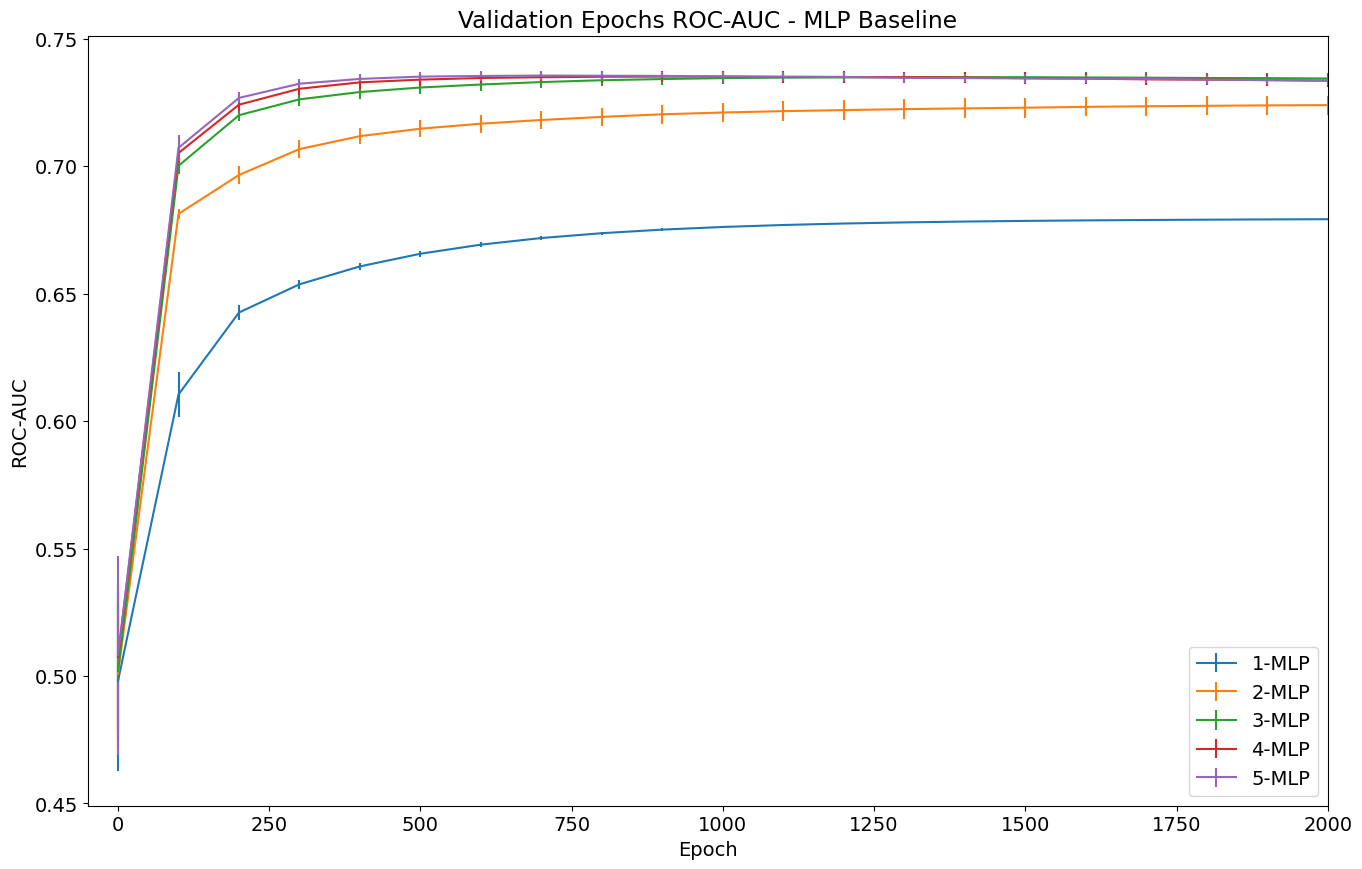

In [32]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation Epochs ROC-AUC - MLP Baseline')

for n_layers in mean_auc_val_dict:
    ax1.errorbar(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'{n_layers}-MLP')

ax1.set_xlim(-50, 2000)

ax1.legend()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC-AUC')

plt.savefig(f'reports/images/structural_omega_dotmlp_training_metrics_multilayer_validation.pdf')